Применить методы кластеризации:
* kmeans,
* DBSCAN + еще (минимум) 1 метод из библиотеки sklearn. 
Разумеется, метки классов должны при этом игнорироваться. Сравнить результаты кластеризации с разбиением на настоящие классы. Сделать выводы.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
sns.set(font_scale=1.4)
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')

В этом ноутбуе будем работать с данными, которые обработали в ноутуке income-classification (1).ipynb

In [2]:
df = pd.read_csv('income_preproc.csv')
print(df.shape)
df.head(3)


(28970, 88)


,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income,x0_Federal-gov,x0_Local-gov,x0_Never-worked,...,x5_Portugal,x5_Puerto-Rico,x5_Scotland,x5_South,x5_Taiwan,x5_Thailand,x5_Trinadad&Tobago,x5_United-States,x5_Vietnam,x5_Yugoslavia
0,0.301370,0.800000,1.0,0.02174,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.800000,1.0,0.00000,0.0,0.122449,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.533333,1.0,0.00000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


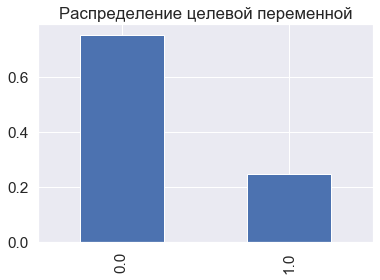

In [3]:
plt.title('Распределение целевой переменной')
df['income'].value_counts(normalize=True).plot(kind='bar')

In [39]:
(trainx,
 testx,
 trainy,
 testy) = train_test_split(df.drop('income',axis=1),
                                  df['income'],
                                  test_size = .3,
                                  random_state=18845
                          )
print(f'trainx: {trainx.shape}\ntestx: {testx.shape}')

trainx: (20279, 87)
testx: (8691, 87)


Для визуализации уменьшим размерность данных. Применим PCA, с 2 компонентами

In [86]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca_train = pca.fit_transform(trainx)
print('Доля объясненной вариации:',
      round(pca.explained_variance_ratio_.sum(),2))


Доля объясненной вариации: 0.29


# DBSCAN

In [88]:
from sklearn.cluster import KMeans, DBSCAN

In [120]:
%%time
from sklearn import preprocessing
# приведение к единичной Евклидовой норме
# quake_normalized = pd.DataFrame(preprocessing.normalize(trainx, 
#                                                         norm="l2"), 
#                                 columns=trainx.columns)

cl_dbscan = DBSCAN(eps=0.15, 
                   min_samples=40,
                   n_jobs=-1,
                   metric='euclidean',
                  )

pred_train = cl_dbscan.fit_predict(trainx,trainy)
print('кол-во кластеров',len(np.unique(pred_train)))

кол-во кластеров 33
Wall time: 13 s


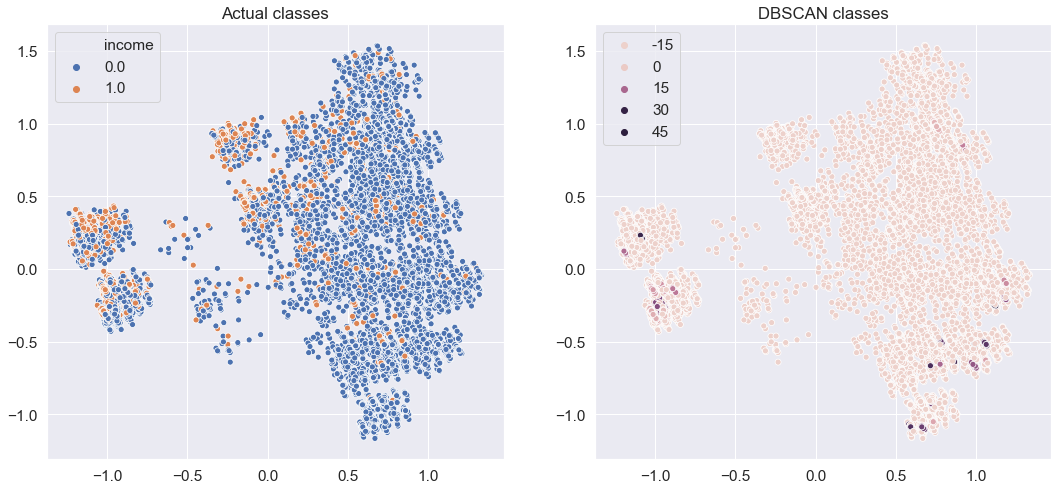

In [128]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('Actual classes')
sns.scatterplot(x = pca_train[:,0], y =pca_train[:,1],hue=trainy )
plt.subplot(122)
plt.title('DBSCAN classes')
sns.scatterplot(x = pca_train[:,0], y =pca_train[:,1],hue=pred_train )

In [123]:
pd.Series(cl_dbscan.labels_).value_counts()


-1     15364
 4       608
 7       559
 8       509
 1       469
 20      266
 2       248
 12      160
 6       124
 18      122
 9       118
 3       112
 21      111
 10      108
 14      106
 24      100
 23       98
 25       96
 0        92
 5        89
 27       87
 15       85
 17       81
 16       75
 19       69
 26       67
 11       67
 28       65
 13       48
 30       48
 22       44
 29       43
 31       41
dtype: int64

кол-во кластеров 11
Wall time: 14.7 s


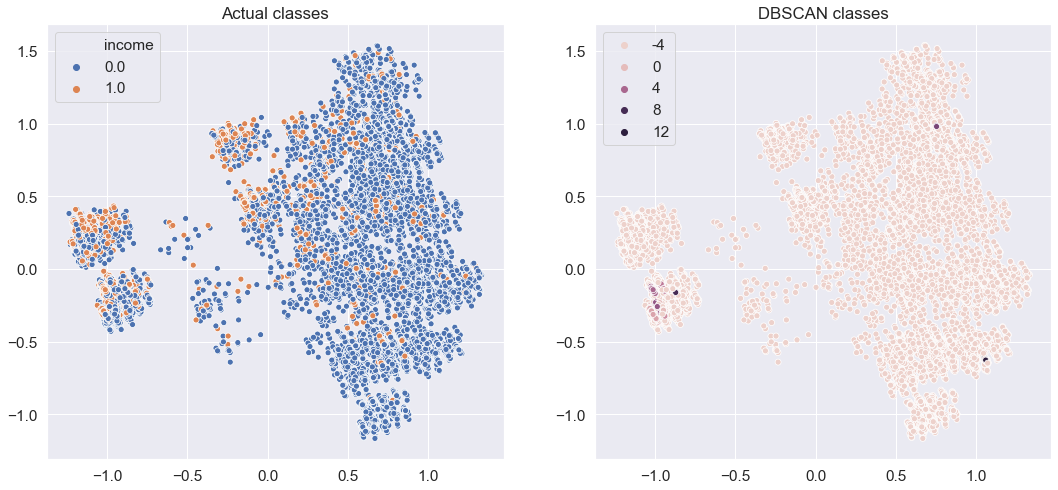

In [137]:
%%time
from sklearn import preprocessing
# приведение к единичной Евклидовой норме
# quake_normalized = pd.DataFrame(preprocessing.normalize(trainx, 
#                                                         norm="l2"), 
#                                 columns=trainx.columns)

cl_dbscan = DBSCAN(eps=0.15, 
                   min_samples=70,
                   n_jobs=-1,
                   metric='euclidean',
                  )

pred_train = cl_dbscan.fit_predict(trainx,trainy)
print('кол-во кластеров',len(np.unique(pred_train)))
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('Actual classes')
sns.scatterplot(x = pca_train[:,0], y =pca_train[:,1],hue=trainy )
plt.subplot(122)
plt.title('DBSCAN classes')
sns.scatterplot(x = pca_train[:,0], y =pca_train[:,1],hue=pred_train )

In [142]:
pd.Series(pred_train).value_counts()

-1    17603
 1      571
 4      546
 2      433
 3      394
 5      236
 0      227
 8       80
 9       70
 6       70
 7       49
dtype: int64

In [140]:
pd.Series(pred_train).map(lambda x: 0 if x==-1 else 1).value_counts()

0    17603
1     2676
dtype: int64

In [141]:
f1_score(trainy, pd.Series(pred_train).map(lambda x: 0 if x==-1 else 1))

0.34123100695338654

In [36]:
trainy.value_counts()

0.0    15189
1.0     5090
Name: income, dtype: int64

# KMEANS

In [74]:
%%time
Z = KMeans(n_clusters = 2, 
           init = 'random',
           n_init = 100,
           max_iter = 1000, 
           random_state=15434,
           n_jobs=-1
          )
Z.fit(trainx)

Wall time: 3.43 s


KMeans(algorithm='auto', copy_x=True, init='random', max_iter=1000,
       n_clusters=2, n_init=100, n_jobs=-1, precompute_distances='auto',
       random_state=15434, tol=0.0001, verbose=0)

In [75]:
Z.inertia_

57987.840627559104

In [76]:
round(f1_score(trainy, Z.predict(trainx)),3)

0.599

In [77]:
round(f1_score(testy, Z.predict(testx)),3)

0.583

C помощью PCA уменьшим размерность до 2

In [86]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca_train = pca.fit_transform(trainx)
print('Доля объясненной вариации:',
      round(pca.explained_variance_ratio_.sum(),2))


Доля объясненной вариации: 0.29


Визуализируем реальные классы и кластера KMeans

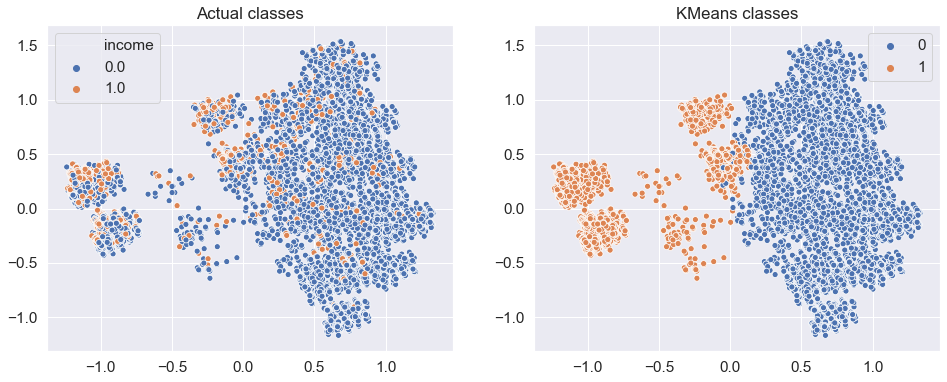

In [84]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Actual classes')
sns.scatterplot(x = pca_train[:,0], y =pca_train[:,1],hue=trainy )
plt.subplot(122)
plt.title('KMeans classes')

sns.scatterplot(x = pca_train[:,0], y =pca_train[:,1],hue=Z.predict(trainx) )


Поссмотрим на иннерцию в зависимости от кол-ва кластеров  

In [ ]:
inertia = []
for k in range(1, data.shape[0]+1):
    Z = KMeans(n_clusters=k, 
               init = 'random',
               n_init = 100,
               max_iter = 1000).fit(data)
    inertia.append(Z.inertia_)

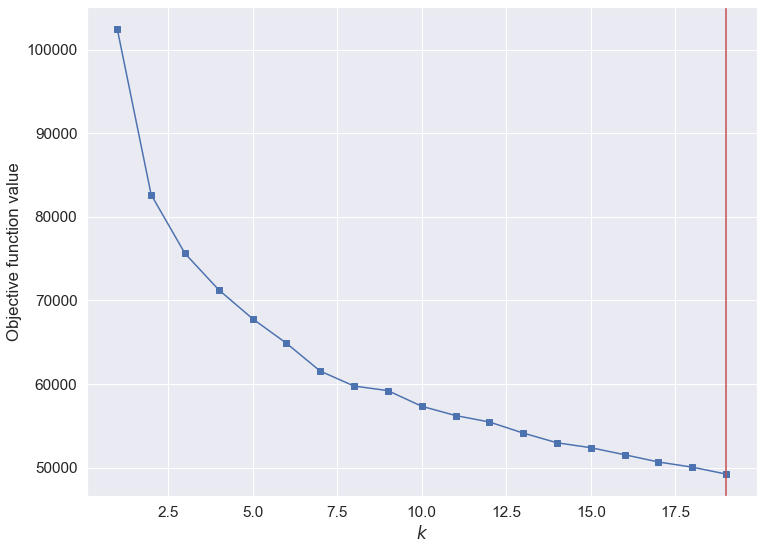

In [87]:
plt.figure(figsize=(12,9))
plt.plot(range(1, 20), inertia, 'bo-', marker='s')
plt.xlabel('$k$')
plt.ylabel('Objective function value')
plt.axvline(x=19, c='r')
plt.show()

Видно, что в этой задачи 2 класстера не дастаточно для хорошей кластеризации 

# AgglomerativeClustering

In [136]:
from sklearn.cluster import AgglomerativeClustering

In [152]:
%%time
pred_train  = AgglomerativeClustering(n_clusters=2).fit_predict(trainx)

Wall time: 1min 1s


f1 on train: 0.573


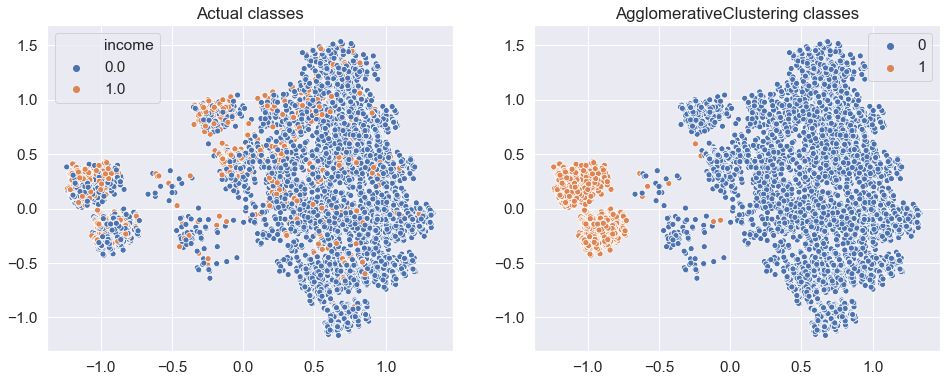

In [153]:
print('f1 on train:',round(f1_score(trainy, pred_train),3))
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Actual classes')
sns.scatterplot(x = pca_train[:,0], y =pca_train[:,1],hue=trainy )
plt.subplot(122)
plt.title('AgglomerativeClustering classes')

sns.scatterplot(x = pca_train[:,0], y =pca_train[:,1],hue=pred_train )

Подбираем гиперпараметры для AgglomerativeClustering

In [155]:
%%time
res = {'linkage':[], 'affinity':[], 'f1_score':[]}
for linkage in ['average', 'complete','single']:
    for metric in ['l1','l2', 'cosine'] :
        pred_train  = AgglomerativeClustering(n_clusters=2,
                                              linkage=linkage,
                                              affinity=metric,   

                                             ).fit_predict(trainx)
        f1 = f1_score(trainy, pred_train)
        res['linkage'].append(linkage)
        res['affinity'].append(metric)
        res['f1_score'].append(f1)
        print(round(f1,3))
res = pd.DataFrame(res)

0.401
0.001
0.401
0.0
0.606
0.109
0.606
0.068
0.0
0.0
0.0
0.0
Wall time: 10min 26s


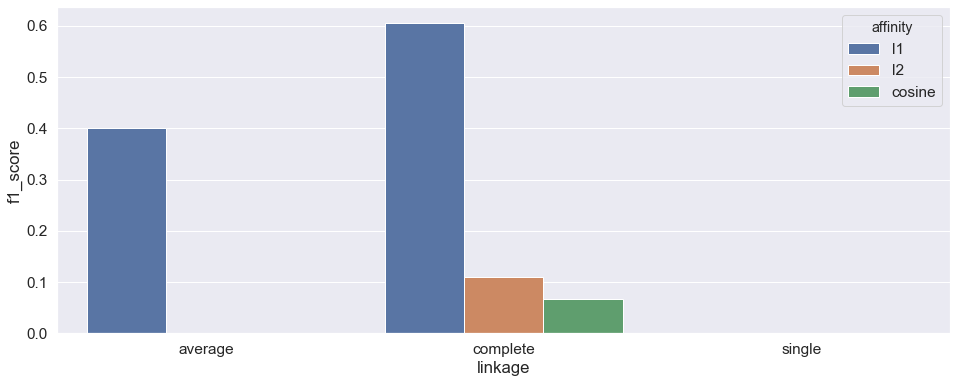

In [173]:
plt.figure(figsize = (16,6))
sns.barplot(x = 'linkage', y = 'f1_score', data = res, hue= 'affinity')

f1 on train: 0.606


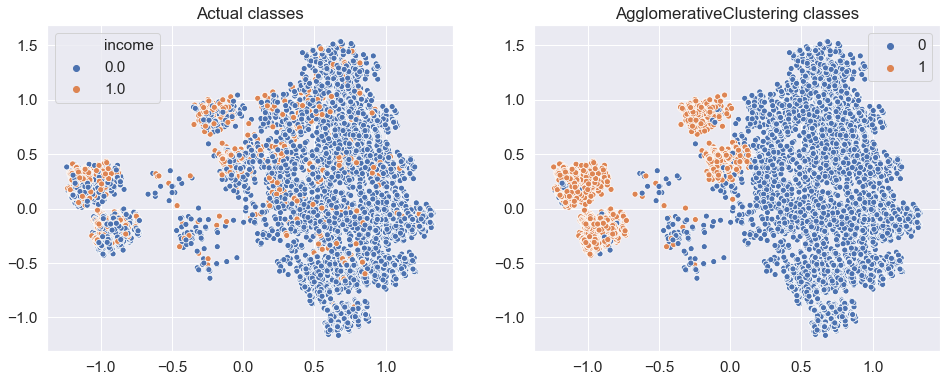

In [166]:
pred_train  = AgglomerativeClustering(n_clusters=2,
                                      linkage = 'complete',
                                      affinity= 'l1',
                                     ).fit_predict(trainx)
print('f1 on train:',round(f1_score(trainy, pred_train),3))
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Actual classes')
sns.scatterplot(x = pca_train[:,0], y =pca_train[:,1],hue=trainy )
plt.subplot(122)
plt.title('AgglomerativeClustering classes')

sns.scatterplot(x = pca_train[:,0], y =pca_train[:,1],hue=pred_train )

Вывод:
* В этой работе не удалось получить хорошие разбиения данных на 2 кластера.
* Среди алгоритмах которые применяли, относительно хорошо работал AgglomerativeClustering 
<br><br>Получили такие точности по f1:
* Kmeans- 0.599 и 0.583 на обучающей и на тестовой выборке соответсвенно
* AgglomerativeClustering - 0.606
* DBSCAN - разделил выборку на больше двух кластеров
